# Exploratory Data Analysis

Closer look on the biggest available datasets about New York's taxis rides.

In [38]:
# Frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Overall information about dataset

In [39]:
df = pd.read_parquet(r'C:\Users\wikto\OneDrive\Dokumenty\AA_projects\road-optimization\data\yellow_tripdata_2025-01.parquet')


# DataFrame shape
print("-" * 30)
print(f"Dataframe shape: {df.shape}")

# All features
print("-" * 30)
print(f"All features: {df.columns}")

# Number of NaN's
print("-" * 30)
print(f"Number of NaN's: {df.isna().sum()}")

------------------------------
Dataframe shape: (3475226, 20)
------------------------------
All features: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')
------------------------------
Number of NaN's: VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount      

### Columns (features)



| Feature | What information does it provide |
| :--- | :--- |
| **VendorID** | Kod dostawcy (1=CMT, 2=VeriFone) |
| **tpep_pickup_datetime** | Czas włączenia taksometru |
| **tpep_dropoff_datetime** | Czas wyłączenia taksometru |
| **passenger_count** | Liczba pasażerów |
| **trip_distance** | Dystans podróży w milach |
| **RatecodeID** | Kod taryfy (1=Standard, 2=JFK, 3=Newark, 5=Negocjowana) |
| **store_and_fwd_flag** | Czy rekord był zapisany w pamięci (Y/N) |
| **PULocationID** | Strefa rozpoczęcia kursu |
| **DOLocationID** | Strefa zakończenia kursu |
| **payment_type** | Płatność (1=Karta, 2=Gotówka, 3=Brak, 4=Spór) |
| **fare_amount** | Opłata taryfowa |
| **extra** | Dodatki (godziny szczytu / nocne) |
| **mta_tax** | Podatek MTA (0.50$) |
| **tip_amount** | Napiwek (tylko płatności kartą) |
| **tolls_amount** | Opłaty drogowe (mosty, tunele) |
| **improvement_surcharge** | Opłata modernizacyjna (0.30$) |
| **total_amount** | Suma całkowita (bez napiwków gotówkowych) |
| **congestion_surcharge** | Opłata za korki |
| **Airport_fee** | Opłata lotniskowa ($1.25) |
| **cbd_congestion_fee** | Opłata za wjazd do centrum (Manhattan) |

Potential columns that are important for our optimatization route model:
tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, RateCodeID, PULocationID, DOLocationID,
fare_amount, extra, tolls_amount, congestion_surcharge, airport_fee, cbd_congestion_fee


fare_amount - > koszt za przejechanie mili + czas spędzony w ruchu 

## Checking error's and NaN's


### trip_distance column analysis

In [40]:
# Checking what unit trip_distance has
df['trip_distance'].head()  # --> CHANGE: mils to km's

df.iloc[2658036]


VendorID                                   1
tpep_pickup_datetime     2025-01-29 14:24:57
tpep_dropoff_datetime    2025-01-29 14:32:04
passenger_count                          2.0
trip_distance                            1.4
RatecodeID                               1.0
store_and_fwd_flag                         N
PULocationID                             233
DOLocationID                             224
payment_type                               1
fare_amount                              9.3
extra                                   3.25
mta_tax                                  0.5
tip_amount                               2.8
tolls_amount                             0.0
improvement_surcharge                    1.0
total_amount                           16.85
congestion_surcharge                     2.5
Airport_fee                              0.0
cbd_congestion_fee                      0.75
Name: 2658036, dtype: object

### fare_amount column analysis

In [41]:

# Is there negative values in fare_amount -> ujemne fare_amount może znaczyć, że przejazd był fałszywy - 
# np. kierowca zapomniał wyłączyć licznika
print((df['fare_amount'] < 0).value_counts()) # --> CHECK or DELETE negative columns

fare_amount
False    3331108
True      144118
Name: count, dtype: int64


### tpep_pickup_datetime and tpep_dropoff_datetime (time difference) columns analysis

In [42]:
# Mean of time difference between pick up and drop off
df['difference'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
mean_diff = df['difference'].mean()
print(f'Mean of time difference: {mean_diff}')
# Std of time difference
std_diff = df['difference'].std()
print(f'Std of time difference: {std_diff}')


# Errors in difference - travel time can't be negative
df['difference'] = df['difference'].astype(np.int64)
(df['difference'] < 0).value_counts()

Mean of time difference: 0 days 00:15:01.086937
Std of time difference: 0 days 00:38:42.814931


difference
False    3475102
True         124
Name: count, dtype: int64

### extra column analysis

In [43]:
df['extra'].isna().value_counts() # No NaN in 'extra' 

(df['extra'] < 0).value_counts() # Negative values = probabbly an error 

extra
False    3445630
True       29596
Name: count, dtype: int64

### congestion surcharge

In [44]:
df['congestion_surcharge'].value_counts()




congestion_surcharge
 2.5    2660818
 0.0     225938
-2.5      48321
Name: count, dtype: int64

### Most common routes


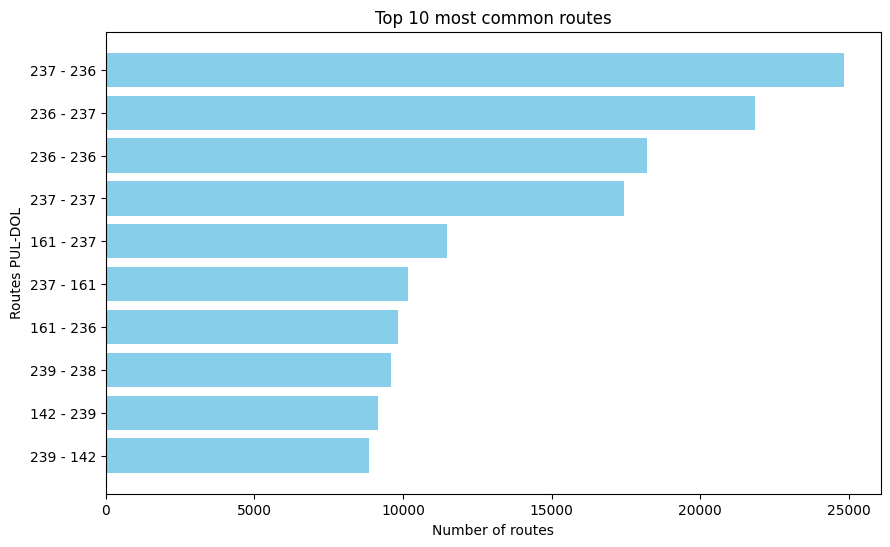

In [49]:
counts_df = df[['PULocationID', 'DOLocationID']].value_counts().reset_index(name='count')

counts_df['route'] = counts_df['PULocationID'].astype(str) + ' - ' + counts_df['DOLocationID'].astype(str)
top_counts = counts_df.head(10)
Y_axis_labels = top_counts['route']
X_axis_values = top_counts['count']


plt.figure(figsize=(10, 6))
plt.barh(Y_axis_labels, X_axis_values, color='skyblue')

plt.xlabel('Number of routes')
plt.ylabel('Routes PUL-DOL')
plt.title('Top 10 most common routes')
plt.gca().invert_yaxis() 
plt.show()